<a href="https://colab.research.google.com/github/nebojsa-bozanic/BMI_OSuM/blob/master/Vezba8%3A%20Obrada%20rendgenske%20slike%3A%20Suzbijanje%20%C5%A1uma%202/OSuM_vezba_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Obrada slike u medicini (BMI)</h1>

Literatura: https://moodle.telekom.ftn.uns.ac.rs/course/view.php?id=82


Laboratorijska vežba 8: Obrada rendgenske slike: Suzbijanje šuma 2

Potrebne biblioteke: cv2, numpy, matplotlib.pyplot, pywt, bm3d, os, scipy.ndimage.filters (convolve1d), osum

In [1]:
!git clone https://github.com/nebojsa-bozanic/BMI_OSuM.git
%cd /content/BMI_OSuM/Vezba8: Obrada rendgenske slike: Suzbijanje šuma 2

Cloning into 'BMI_OSuM'...
remote: Enumerating objects: 832, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 832 (delta 102), reused 125 (delta 57), pack-reused 606
Receiving objects: 100% (832/832), 276.70 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (289/289), done.
Updating files: 100% (245/245), done.
/content/BMI_OSuM/Vezba8: Obrada rendgenske slike: Suzbijanje šuma 2


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import osum
import pywt

from google.colab.patches import cv2_imshow

1. Modifikacije sigmoidalne krive za multiveličinsko pojačanje

Ako pretpostavimo da na višim nivoima piramide dominira šum, multiveličinsko pojačanje struktura običnom sigmoidalnom krivom dodatno pojačava šum na tim nivoima. Uvodimo dve modifikacije sigmoidalne krive kako bismo prevazišli ovaj problem.

Ublaženo pojačanje

1.1 U modulu osum napraviti funkciju sigmLUT_lin modifikacijom sigmLUT tako da niske vrednosti budu mapirane linearno. Ulazni parametri funkcije su ulazni opseg, izlazni opseg, nagib i procenat opsega oko nule koji se transformiše linearno.

In [3]:
def sigmLUT_lin(ip_range, op_range, k, t=0.05):

    k = k*2/op_range
    lut = 2*op_range*(1/(1+np.exp(-k*(np.arange(-ip_range, ip_range+1))))-0.5)

    sum_tol = int(lut.size*t)  # broj piksela oko nule
    lin_deo = np.arange(-sum_tol, sum_tol+1)
    lut[lin_deo+ip_range] = lin_deo

    return lut

1.2 U skripti v8_1.py Napraviti LUT za običnu sigmoidalnu transformaciju kojom se transformiše ulazni opseg -2000 do 2000 u opseg -800 do 800 sa nagibom 7. Prikazati LUT.

Text(0.5, 1.0, 'LUT za sigmoidalno pojacanje')

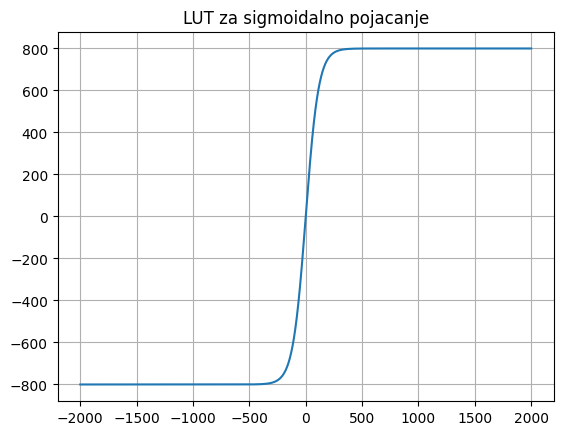

In [4]:
sigLUT = osum.sigmLUT(2000, 800, 7)
plt.figure()
plt.plot(np.arange(-2000, 2001), sigLUT)
plt.grid()
plt.title('LUT za sigmoidalno pojacanje')


1.3 Napraviti LUT za modifikovanu sigmoidalnu transformaciju sa linearnim delom
koristeći iste parametre kao u prethodnoj tački i 6% opsega koji se transformiše
linearno. Prikazati ovaj LUT.

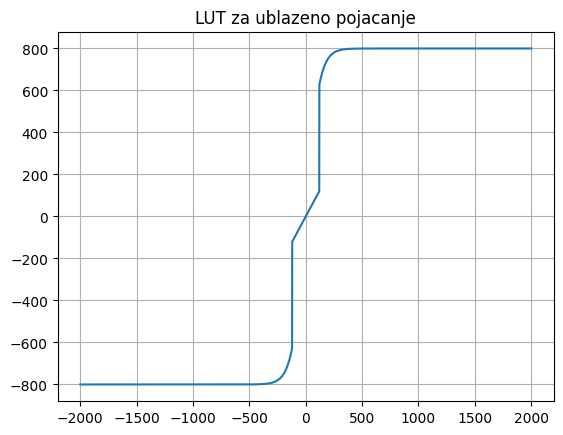

In [5]:
sigLUT_lin = osum.sigmLUT_lin(2000, 800, 7, 0.03)
plt.figure()
plt.plot(np.arange(-2000, 2001), sigLUT_lin)
plt.grid()
plt.title('LUT za ublazeno pojacanje')
plt.show()

1.4 Učitati sliku Ro_01.fxd i uraditi logaritamsku kompresiju opsega (im_log).

In [6]:
[im, DetInfo, hdr] = osum.read_raw('Ro_01.fxd')
logLUT = osum.log_LUT(16384, 4096, 0.001)
im_log = logLUT[im]

1.5 Napraviti Laplasovu piramidu i primeniti napravljene LUT za pojačanje detalja na prvom nivou.

In [7]:
Lpyr, Gpyr, Res, size_vec = osum.im_pyr_decomp(im_log, 2)
L1 = Lpyr[0]

Lk1 = sigLUT[np.uint16(L1+2000)]
Lpyr1 = Lpyr
Lpyr1[0] = Lk1

Lk2 = sigLUT_lin[np.uint16(L1+2000)]
Lpyr2 = Lpyr
Lpyr2[0] = Lk2

1.6 Rekonstruisati slike, prikazati ih i analizirati razlike.

Text(0.5, 1.0, 'Ublazeno sigmoidalno pojacanje')

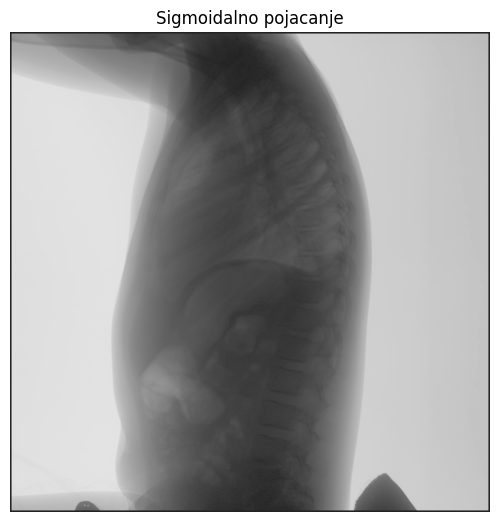

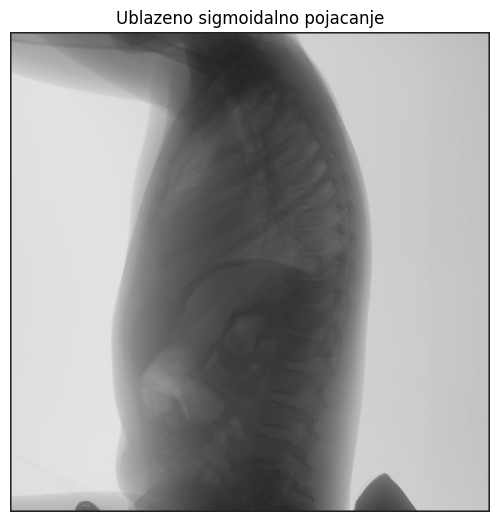

In [8]:
im_rec1 = osum.im_pyr_recon(Lpyr1, Res, size_vec)
im_rec2 = osum.im_pyr_recon(Lpyr2, Res, size_vec)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im_rec1, cmap='gray', vmin=im_rec1.min(), vmax=im_rec1.max())
plt.axis('off')
plt.title('Sigmoidalno pojacanje')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im_rec2, cmap='gray', vmin=im_rec2.min(), vmax=im_rec2.max())
plt.axis('off')
plt.title('Ublazeno sigmoidalno pojacanje')


1.7 Isprobati različite vrednosti parametra t u sigmLUT_lin. Takođe isprobati sve na 2. nivou i na prvom i drugom nivou u isto vreme. Direktno potiskivanje šuma

1.8 Druga modifikacija sigmoida podrazumeva da se niski koeficijenti potpuno potisnu, tj. da se svedu na 0. U modulu osum napraviti funkciju sigmLUT_z u kojoj se implementira ova modifikacije. Ulazni parametri su ulazni opseg, izlazni opseg, nagib i procenat opsega oko nule koji se suzbija.

In [9]:
def sigmLUT_z(ip_range, op_range, k, t=0.05):

    k = k*2/op_range
    lut = 2*op_range*(1/(1+np.exp(-k*(np.arange(-ip_range, ip_range+1))))-0.5)

    # t se prosledjuje kao procenat u opsegu [0,1]
    if t<1:
        sum_tol = int(lut.size*t)
        lin_deo = np.arange(-sum_tol, sum_tol+1)
        lut[lin_deo+ip_range] = 0
    # 2.3 t se prosledjuje kao prag intenziteta
    else:
        x = np.arange(-ip_range, ip_range+1)
        lut[abs(x)<t] = 0

    return lut

1.9 Napraviti LUT za ovu modifikovanu sigmoidalnu transformaciju sa parametrima kao u 1.3. Prikazati LUT i uporediti ga sa običnom sigmoidalnom transformacijom.

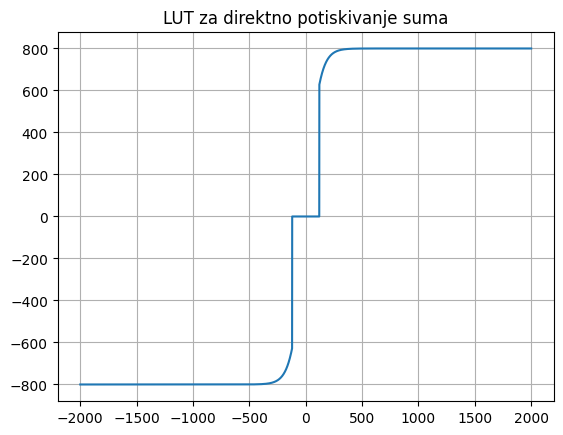

In [10]:
sigLUT_z = osum.sigmLUT_z(2000, 800, 7, 0.03)
plt.figure()
plt.plot(np.arange(-2000, 2001), sigLUT_z)
plt.grid()
plt.title('LUT za direktno potiskivanje suma')
plt.show()


1.10 Primeniti ovaj LUT na prvi nivo LP, rekonstruisati sliku i analizirati je.


Text(0.5, 1.0, 'Direktno potiskivanje suma')

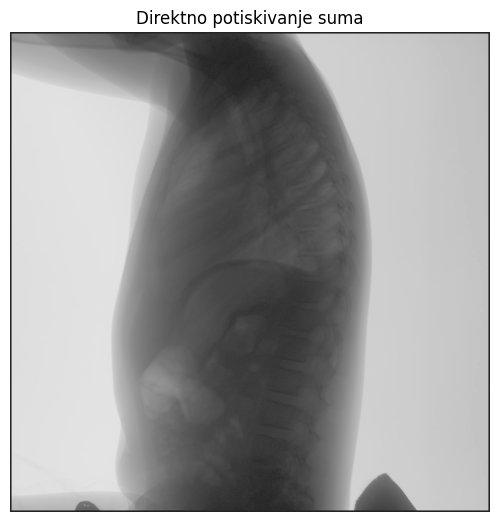

In [11]:
Lpyr, Gpyr, Res, size_vec = osum.im_pyr_decomp(im_log, 2)
L1 = Lpyr[0]

Lk3 = sigLUT_z[np.uint16(L1+2000)]
Lpyr3 = Lpyr
Lpyr3[0] = Lk3
im_rec3 = osum.im_pyr_recon(Lpyr3, Res, size_vec)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im_rec3, cmap='gray', vmin=im_rec3.min(), vmax=im_rec3.max())
plt.axis('off')
plt.title('Direktno potiskivanje suma')


1.11 Isprobati različite vrednosti parametra t u sigmLUT_z. Takođe isprobati sve na 2. nivou i na prvom i drugom nivou u isto vreme.

2. Procena šuma iz vejvlet piramide

Deo opsega koji se suzbija u modifikovanim sigmoidalnim krivama može se preciznije proceniti kao (umnožak) standardne devijacije šuma. Dijagonalni koeficijenti najviših nivoa vejvlet piramide potiču skoro potpuno od šuma što se može iskoristiti za procenu std.

2.1 U promenljivu im2 učitati sliku abdomen.png i razložiti je u vejvlet piramidu sa 2 nivoa koristeći vejvlet db4.

Text(0.5, 1.0, 'cD1')

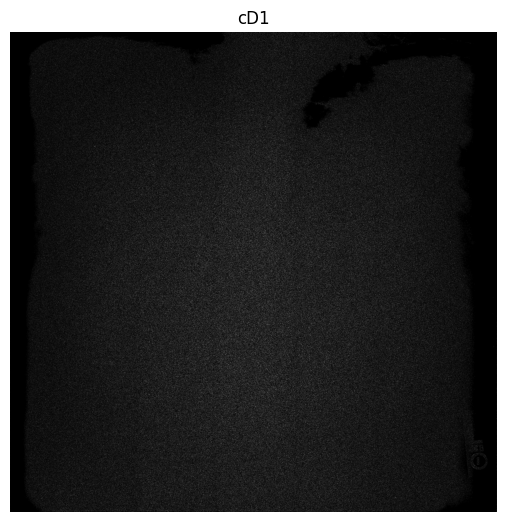

In [12]:
im2 = cv2.imread('abdomen.png', cv2.IMREAD_GRAYSCALE)

w = 'db4'
n = 2
C = pywt.wavedec2(im2, wavelet=w, mode='periodization', level=n)

cA2 = C[0]
(cH2, cV2, cD2) = C[1]
(cH1, cV1, cD1) = C[2]
C = [list(c) for c in C]  # pretvaramo iz tuple u listu da bismo mogli da menjamo

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(abs(cD1), cmap='gray', vmin=abs(cD1).min(), vmax=abs(cD1).max())
plt.axis('off')
plt.title('cD1')


2.2 Proceniti standardnu devijaciju šuma sa dijagonalnih koeficijenata prvog nivoa piramide koristeći formulu: 𝜎! = 𝑚𝑒𝑑𝑖𝑎𝑛(|𝐷"|) 0.6745

In [13]:
sigma = np.median(np.abs(cD1))/0.6745

2.3 Modifikovati sigmLUT_z tako da je moguće uneti apsolutnu vrednost intenziteta ispod koga će koeficijenti biti suzbijeni.

2.4 Napraviti LUT za sigmoidalno pojačanje i LUT sa direktnim potiskivanjem šuma
koristeći parametre ip_range=1000, op_range=800, k=7 i nivo intenziteta 3𝜎!.

In [14]:
sigLUT = osum.sigmLUT(1000, 800, 7)
sigLUT_z = osum.sigmLUT_z(1000, 800, 7, 3*sigma)


2.5 Rekonstruisati slike sa modifikovanim prvim nivoom vejvlet piramide u dijagonalnom pravcu i uporediti ih.

Text(0.5, 1.0, 'Direktno potiskivanje suma')

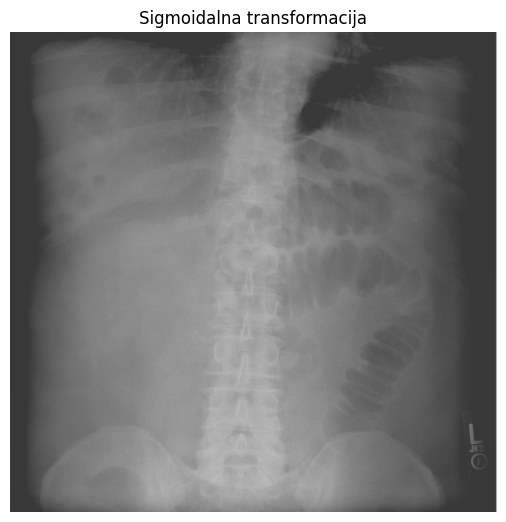

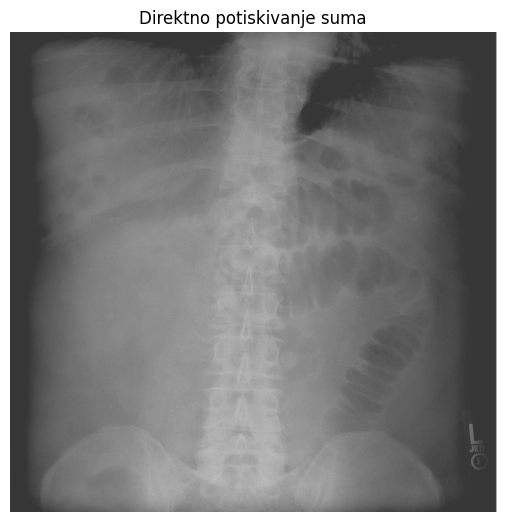

In [15]:
cD1_k = sigLUT[np.uint16(cD1+1000)]
cD1_k2 = sigLUT_z[np.uint16(cD1+1000)]

C[2][2] = cD1_k
im_rec1 = pywt.waverec2(C, wavelet=w, mode='periodization')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im_rec1, cmap='gray', vmin=im_rec1.min(), vmax=im_rec1.max())
plt.axis('off')
plt.title('Sigmoidalna transformacija')

C[2][2] = cD1_k2
im_rec2 = pywt.waverec2(C, wavelet=w, mode='periodization')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.imshow(im_rec2, cmap='gray', vmin=im_rec2.min(), vmax=im_rec2.max())
plt.axis('off')
plt.title('Direktno potiskivanje suma')


In [16]:
!pip install bm3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:00


In [17]:
import bm3d

3. Sličnost po blokovima

3.1 U skripti v8_2.py u promenljivu im učitati sliku abdomen_crop.png.

In [18]:
im = cv2.imread('abdomen_crop.png', cv2.IMREAD_GRAYSCALE)

3.2 Primenti Non-local Means filtar na sliku im koristeći parametre
templateWindowSize=11, searchWindowSize=11, n=9. Prikazati dobijenu sliku I
uporediti je sa slikom pre filtriranja.

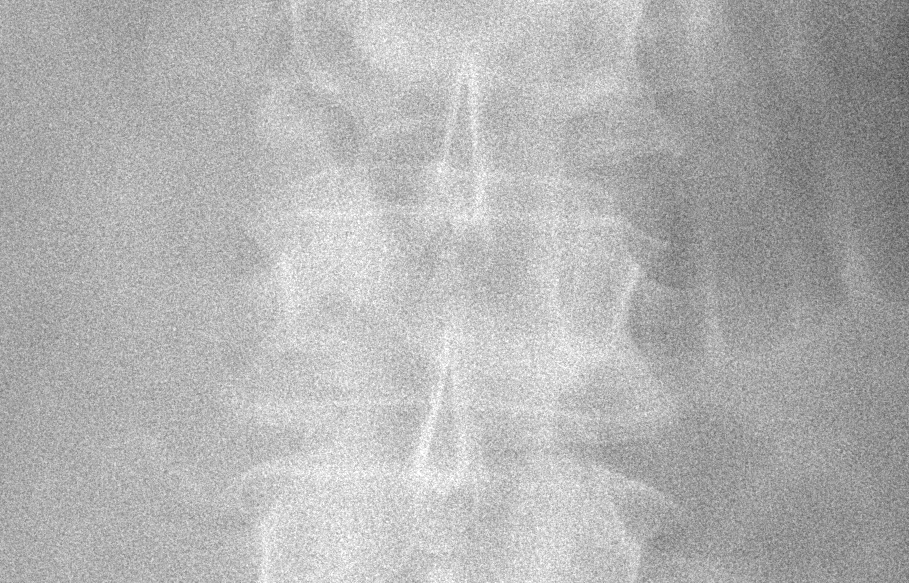

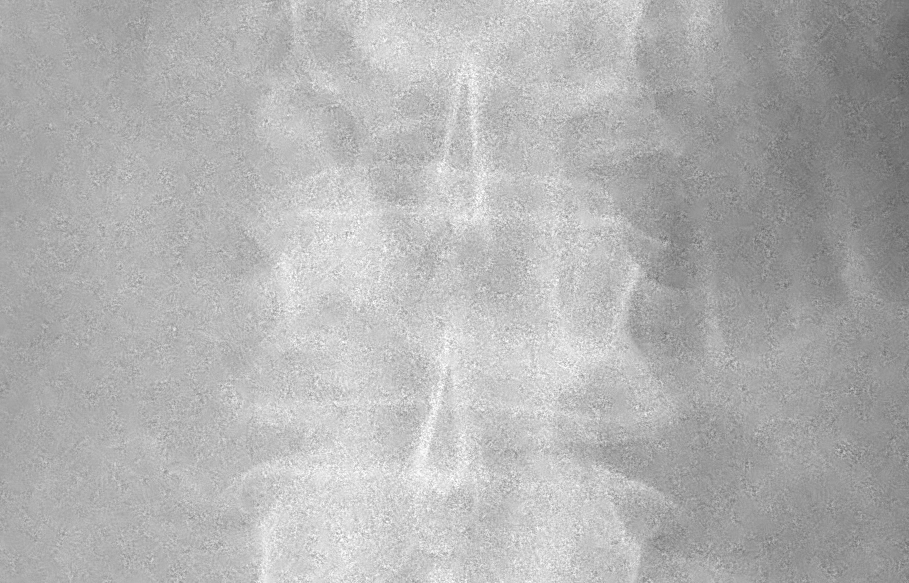

In [19]:
im_f1 = cv2.fastNlMeansDenoising(im, templateWindowSize=11, searchWindowSize=11, h=9)
# vece h - vise se ocuvavaju ivice ali i sum
# templateWindow i searchWindow ne moraju da budu istih dimenzija

cv2_imshow(im) # 'Originalna slika',
cv2_imshow(im_f1) # 'Non-local Mens',

3.3 Primeniti bm3d filtar na sliku im. Primeniti oba stepena (filtraciju pragovanjem i Vinerov filtar), a standardnu devijaciju proceniti na osnovu dijagonalnih koeficijenata prvog nivoa vejvlet piramide (kao u prethodnom delu). Prikazati sliku pre i posle filtriranja.

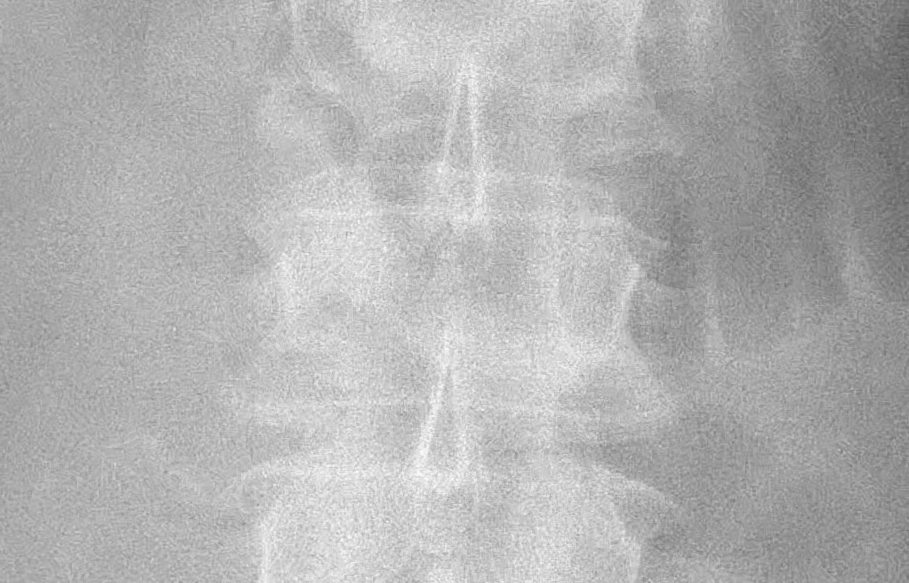

In [20]:
w = 'db4'
n = 2
C = pywt.wavedec2(im, wavelet=w, mode='periodization', level=n)
cA2 = C[0]
(cH2, cV2, cD2) = C[1]
(cH1, cV1, cD1) = C[2]
C = [list(c) for c in C]

sigma = np.median(np.abs(cD1))/0.6745
im_f2 = bm3d.bm3d(im, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES)

cv2_imshow(np.uint8(im_f2)) # 'BM3D',

4. Temporalno filtriranje

4.1 U skripti v8_3.py učitati fluoroskopsku sekvencu iz foldera Img_1 u 3D matricu im_sekv

In [21]:
import os
from scipy.ndimage.filters import convolve1d

d = 'Img_1'
files = [os.path.join(d,f) for f in sorted(os.listdir(d))]
[im, DetInfo, hdr] = osum.read_raw(files[0])

im_sekv = np.zeros((im.shape[0], im.shape[1], len(files)))

<ipython-input-21-6720f941b597>:2: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve1d


4.2 Napraviti LUT za logaritamsku kompresiju opsega sa ulaznim i izlaznim opsegom 2"# i tolerancijom ulaznog opsega 0.1 %

In [22]:
logLUT = osum.log_LUT(2**16, 2**16, 0.001)

4.3 Definisati parametre za pravljenje video zapisa

In [23]:
fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
fps = 4  # proizvoljno
frame_size = (im.shape[0], im.shape[1])
isColour = 0
video_out = cv2.VideoWriter('fluoro.avi', fourcc, fps, frame_size, isColour)

4.4 U for petlji učitati frejm po frejm i primeniti log kompresiju opsega. Invertovati vrednosti i upisati frejm u video sekvencu u opsegu uint8

In [24]:
for i in range(len(files)):
    [im, DetInfo, hdr] = osum.read_raw(files[i])
    im = logLUT[im]
    im_sekv[:,:,i] = im
    video_out.write(np.uint8((1-osum.im_norm(im))*255))

video_out.release()

4.5 Definisati 1D Gausov filtar sa parametrima n=11 i sigma=2. Primeniti ovaj filtar za filtriranje sekvence kroz vreme (temporalno filtriranje) i sačuvati je u im_f.

In [25]:
g, x_osa = osum.gaussian(11, 2)
im_f = convolve1d(im_sekv, g, axis=2, mode='nearest')

4.6 Napravit video zapis od sekvence im_f.

In [26]:
video_out2 = cv2.VideoWriter('fluoro_filt.avi', fourcc, fps, frame_size, isColour)
for i in range(im_f.shape[2]):
    fr = im_f[:,:,i]
    video_out2.write(np.uint8((1-osum.im_norm(fr))*255))

video_out2.release()
